In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [31]:
# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)
# Populate Bath cell with isotopes
diamond.add_isotopes(('13C', 0.011))
# Set z-direction of the bath (defect)
diamond.zdir = [1, 1, 1]
# Generate spin bath
### Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

# Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
# Setting up the Simulator

### Parameters of CCE calculations engine
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
# alpha = [0, 0, 1]; beta = [0, 1, 0] # This was for spin=1
# # For spin=1/2:
alpha = [1, 0]  # |0⟩ state
beta = [0, 1]  # |1⟩ state

In [32]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter

D = 0  # in kHz

# start = 2e2
# stop = 1.8e6
# num = 1

# D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz
# D_list = np.linspace(start, stop, num=num)

#############################################
# ZFS E parameter

E = 0

# E_start = 1
# E_stop =( 1.8e3 ) /3
# E_num = 1
# E_list = np.logspace(np.log10(E_start), np.log10(E_stop), num=E_num) 
# E_list = np.linspace(E_start, E_stop, num=E_num)

# E_list = [139.24798] # Note for later, this value of E give remarkably high coherence??

##########################################################################################
### Other parameters
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
            ('13C',  1 / 2,  6.72828),
            ('29Si', 1 / 2, -5.3188),]

# Time points
time_space = np.linspace(0, 2, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1

##########################################################################################
# Mag. Field (Bx By Bz)

start = 1
stop = 1000
num = 10

B_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz

# b = np.array([0, 0, 0])  # in G
##########################################################################################


coherence_list = []
coherence_dict = {}

for B in B_list:
    # Define the central spin
    nv = pc.CenterArray(spin=0.5, position=position, D=D, E=E, alpha=alpha, beta=beta)

    atoms.add_type(*spin_types)
    print(nv)

    # Setting the Simulator object
    ### Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=atoms,
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    print(calc)
    # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
    nspin = calc.bath
    # Set model quadrupole tensor at N atom
    quad = np.asarray([[-2.5, 0, 0],
                        [0, -2.5, 0],
                        [0, 0,  5.0]]) * 1e3 * 2 * np.pi

    nspin['Q'][nspin['N'] == '14N'] = quad
    # print(calc)

    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x',np.pi)]
    # pulse_sequence += [pc.Pulse('z',np.pi)]
    # pulse_sequence += [pc.Pulse('y',np.pi)]

    b = np.array([0, 0, B])  # in G

    # Calculate coherence function
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                pulses=pulse_sequence,
                                method='gcce', quantity='coherence')
    
    # At the end of your inner loop:
    key = (B)
    coherence_dict[key] = l_generatilze

CenterArray
(s: [0.5],
xyz:
[[0. 0. 0.]],
zfs:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])
Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.

CenterArray
(s: [0.5],
xyz:
[[0. 0. 0.]],
zfs:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])
Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.

CenterArray
(s: [0.5],
xyz:
[[0. 0. 0.]],
zfs:
[[[0. 0. 0.]
  [0

/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_12026/164987491.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time/T2)**beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_12026/164987491.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time/T2)**beta)


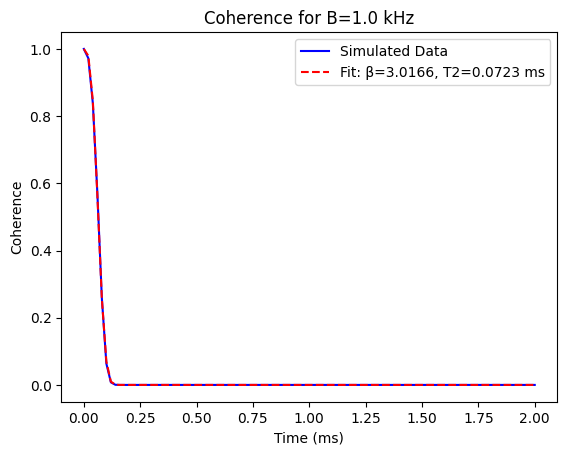

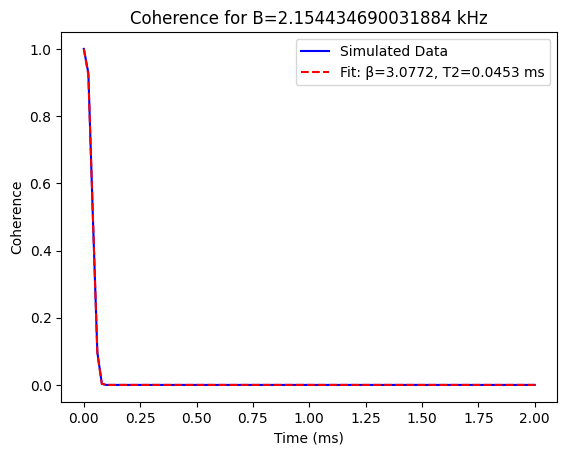

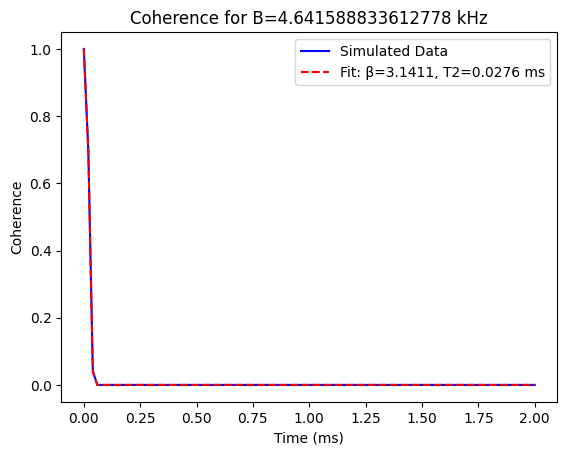

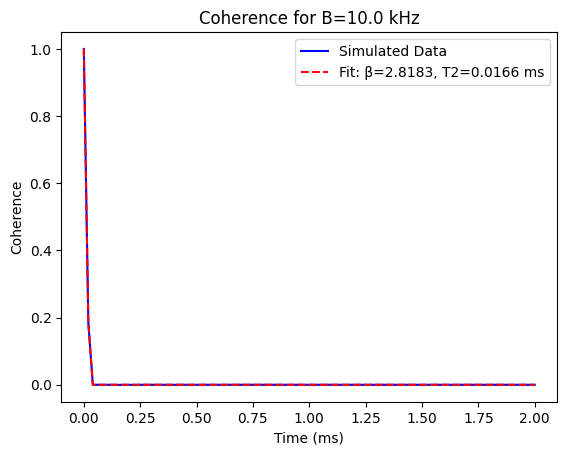

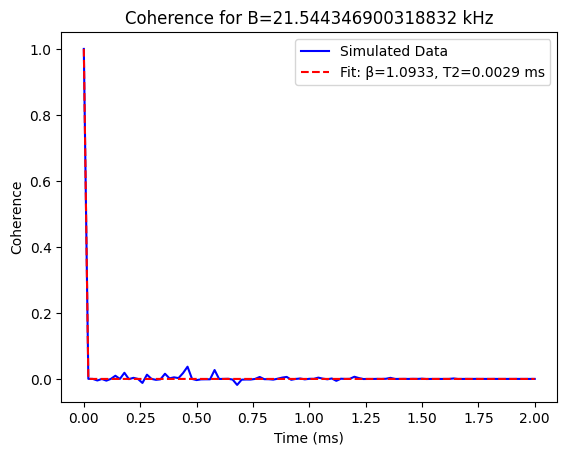

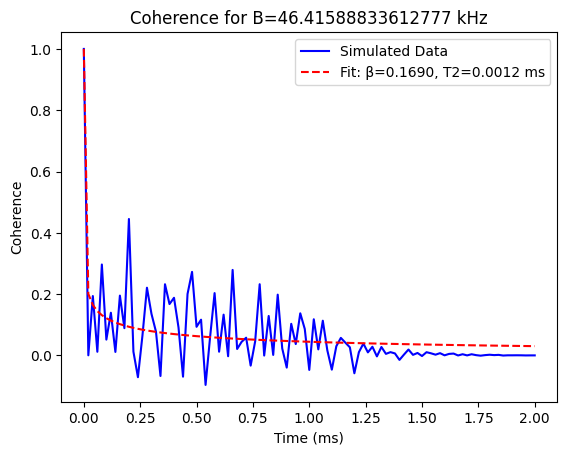

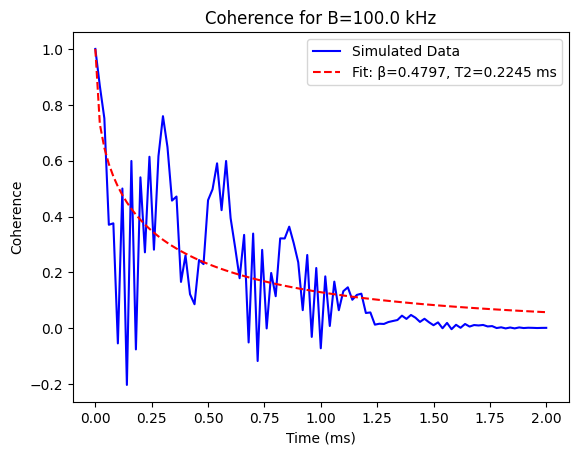

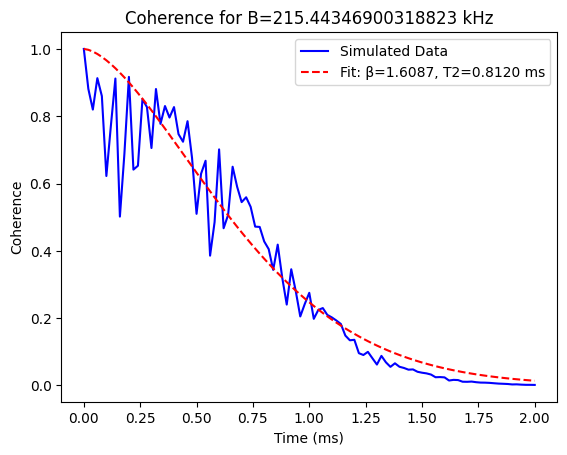

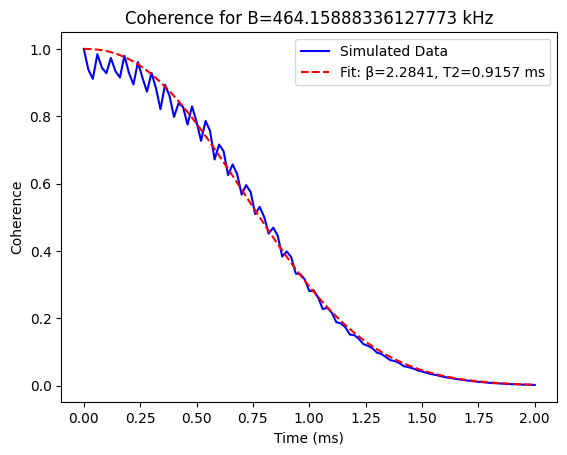

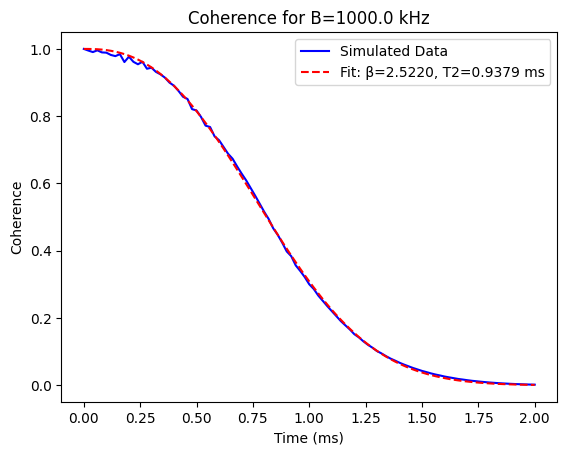

B = 1.0 kHz: T2 = 0.0723 ms
B = 2.154434690031884 kHz: T2 = 0.0453 ms
B = 4.641588833612778 kHz: T2 = 0.0276 ms
B = 10.0 kHz: T2 = 0.0166 ms
B = 21.544346900318832 kHz: T2 = 0.0029 ms
B = 46.41588833612777 kHz: T2 = 0.0012 ms
B = 100.0 kHz: T2 = 0.2245 ms
B = 215.44346900318823 kHz: T2 = 0.8120 ms
B = 464.15888336127773 kHz: T2 = 0.9157 ms
B = 1000.0 kHz: T2 = 0.9379 ms


In [39]:
def coherence_time_func(time,beta,T2):
    return np.exp(-(time/T2)**beta)

# Fit the coherence time
from scipy.optimize import curve_fit

# Storage for T2 values
T2_values = {}
beta_values = {}

# Loop through each B value
for B in unique_B_values:
    coherence_data = coherence_dict[B]

    # Try to fit the data
    try:
        popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
        beta_fitted, T2_fitted = popt
        beta_values[B] = beta_fitted
        T2_values[B] = T2_fitted
        
        # Plot the data and the fit
        # plt.figure(figsize=(10,7))
        plt.plot(time_space, coherence_data, 'b-', label='Simulated Data')
        plt.plot(time_space, coherence_time_func(time_space, *popt), 'r--', label=f'Fit: β={beta_fitted:.4f}, T2={T2_fitted:.4f} ms')
        plt.title(f'Coherence for B={B} kHz')
        plt.xlabel('Time (ms)')
        plt.ylabel('Coherence')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error fitting for B = {B} kHz: {e}")
        beta_values[B] = None
        T2_values[B] = None

# Print the extracted fit values
for B, T2 in T2_values.items():
    print(f"B = {B} kHz: T2 = {T2:.4f} ms")

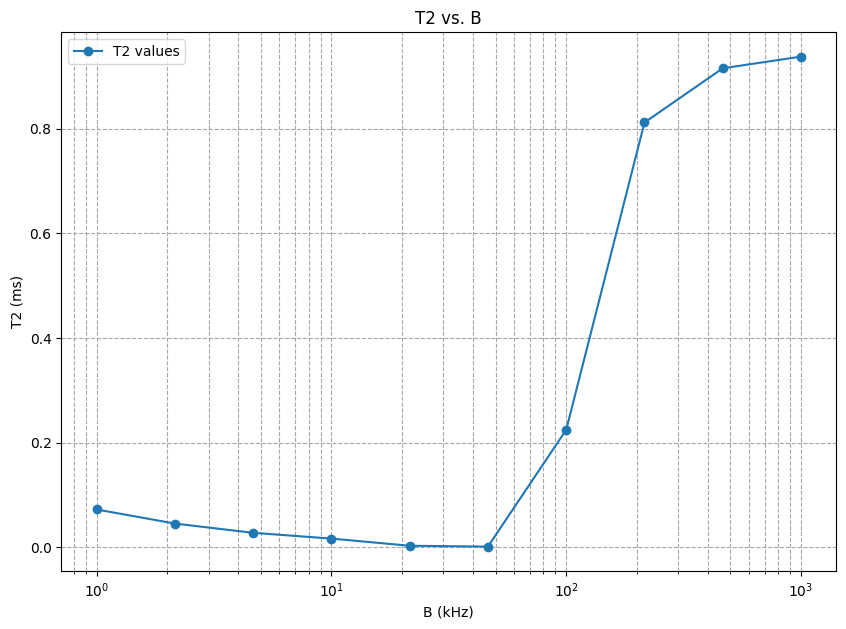

In [37]:
# Extract B values and corresponding T2 values
B_values = list(T2_values.keys())
T2_list = list(T2_values.values())

# Plot T2 vs B
plt.figure(figsize=(10,7))
plt.semilogx(B_values, T2_list, 'o-', label='T2 values')  # Using a log-scale for the x-axis since B_list is on a logarithmic scale
plt.title('T2 vs. B')
plt.xlabel('B (kHz)')
plt.ylabel('T2 (ms)')
plt.grid(True, which="both", ls="--", c='0.65')
plt.legend()
plt.show()
